In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [51]:
########### MODEL CLASSES ###############
N = 4

class NormalizationLayer(nn.Module):
    def __init__(self, R, maxnorm, input_shape):
        super(NormalizationLayer, self).__init__()
        self.maxnorm = maxnorm
        self.R = R
        self.weight = torch.nn.Parameter(data=torch.randn(input_shape),requires_grad=True)
        self.sigmoid = nn.Sigmoid()
        self.a = torch.nn.Parameter(data=torch.randn(input_shape[0],1), requires_grad=True)
        
        
    def forward(self, inputs):
        rotation_vector = self.weight / torch.norm(self.weight, dim=1, p=2, keepdim=True)
        theta = torch.atan(rotation_vector[:,1]/rotation_vector[:,0])
        pi = torch.pi
        constant =  math.cos(pi / N)
        floor_term = torch.floor((N * theta + pi) / (2 * pi))
        denominator = torch.cos(theta - (2 * pi / N) * floor_term)
        length = constant * (self.R.squeeze(-1) - self.R.squeeze(-1)*self.maxnorm.squeeze(-1)) / denominator
        allowed_length = length.unsqueeze(-1)
        output = inputs * rotation_vector * allowed_length * self.sigmoid(self.a)
        return output
    
class NoiseLayer(nn.Module):
    def __init__(self, noise_radius):
        super(NoiseLayer, self).__init__()
        self.noise_radius = noise_radius
        self.alpha = 0.5
        self.beta = 0.5
        
    def spherical_gaussian(self, num_circles):
        x = torch.randn(num_circles, 2)
        beta_distribution = torch.distributions.Beta(self.alpha, self.beta)
        u = beta_distribution.sample((num_circles,2))
        norm = torch.norm(x, dim=1, keepdim=True, p=2)
        noise = x * (u) * self.noise_radius / norm
        return noise

    def forward(self, inputs, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        noise = self.spherical_gaussian(inputs.size(0))
        return inputs + noise
    

class EncoderDecoder(nn.Module):
    def __init__(self, num_circles, larger_radius, smaller_radius):
        super(EncoderDecoder, self).__init__()
        
        self.main_dim = num_circles
        self.latent_dim = 2
        self.R = larger_radius
        self.r = smaller_radius
        self.mid_dim = 30
        self.alpha = 0.5

        self.normalize = NormalizationLayer(self.R, self.r, (num_circles, 2))       
        self.noise = NoiseLayer(self.r)
        
        self.encoder = nn.Sequential(
            nn.Linear(self.main_dim, self.mid_dim),
            nn.SELU(),
            nn.Linear(self.mid_dim, self.main_dim),
            nn.SELU(),
            nn.Linear(self.main_dim, self.latent_dim),
            nn.Tanh()
        )       
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.main_dim),
            nn.ReLU(),
            nn.Linear(self.main_dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, self.main_dim),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x, alpha, beta):
        encoded = self.encoder(x)
        normed_encoded = self.normalize(encoded)
        noisy_encoded = self.noise(normed_encoded, alpha, beta)
        decoded = self.decoder(noisy_encoded)
        return decoded

    def centres(self, x):
        return self.normalize(self.encoder(x)).detach().numpy()

In [52]:
def one_hot(a, num_classes):
    return torch.tensor(np.eye(num_classes)[a], dtype=torch.float32)

In [53]:
def plot_circles(centres, large_radius, small_radius, save = False, savename=None):
    fig, ax = plt.subplots(figsize = (3, 3))
    ax.axis('off')
    ax.scatter(0,0, color = 'red')
    ax.add_patch(plt.Rectangle((-1,-1), 2, 2, fill = False, linewidth = 2.0, color = 'black'))
    ax.axis('scaled')
    i=0
    for rad, centre in enumerate(centres):
        (x,y) = centre
        #ax.annotate(str(rad+1), (x,y), (x,y), fontsize = 16)
        ax.add_patch(plt.Circle(centre, radius = small_radius[i], fill = False, linewidth = 1.0, color = 'blue'))
        i += 1
    if save:
        plt.savefig(savename)
    plt.show()

def packing_density(centres, r, R = 1, NumSamples = 100000):
    '''
    centres: centres of the spheres [N,2], N: Number of spheres
    r: radius of each circle
    R: radius of enclosing circle
    NumSamples: number of points to be sampled towards density calculation
    '''
    x = np.random.normal(size=[NumSamples, 2])
    u = np.random.uniform(size=[NumSamples, 1])
    norm = np.linalg.norm(x, axis = 1, keepdims=True)
    # r = np.expand_dims(r, axis=(1, 2))
    # r = np.repeat(r, NumSamples, axis=1)
    # r = np.squeeze(r, axis=-1)

    #these points are distributed uniformly inside the circle
    coordinates = x*np.power(u, 1/2)/norm*R[0] 
    centres_reshaped = np.reshape(centres, [1, centres.shape[0], centres.shape[1]])
    coordinates_reshaped = np.reshape(coordinates, [coordinates.shape[0], 1, coordinates.shape[1]])
    distances_from_centres = np.linalg.norm(coordinates_reshaped - centres_reshaped, axis = 2)

        
    return np.sum(np.any(distances_from_centres<r.T, axis=1))/NumSamples

  0%|          | 0/7000 [00:00<?, ?it/s]

Epcoh 0
Packing Density : 0.19727
Circle Config : 


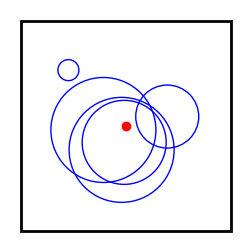

  0%|          | 1/7000 [00:00<1:36:43,  1.21it/s]

##########################


  1%|▏         | 100/7000 [00:55<1:03:59,  1.80it/s]

Epcoh 100
Packing Density : 0.33352
Circle Config : 


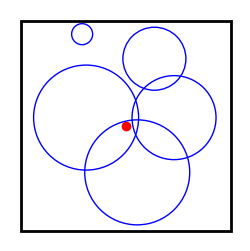

  1%|▏         | 101/7000 [00:56<1:06:34,  1.73it/s]

##########################


  3%|▎         | 200/7000 [01:51<1:02:29,  1.81it/s]

Epcoh 200
Packing Density : 0.34071
Circle Config : 


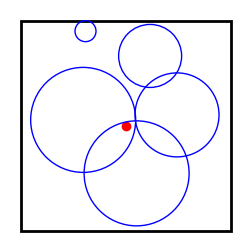

  3%|▎         | 201/7000 [01:51<1:04:17,  1.76it/s]

##########################


  4%|▍         | 300/7000 [02:47<1:06:03,  1.69it/s]

Epcoh 300
Packing Density : 0.34874
Circle Config : 


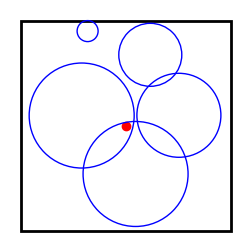

  4%|▍         | 301/7000 [02:47<1:08:36,  1.63it/s]

##########################


  6%|▌         | 400/7000 [03:44<1:15:48,  1.45it/s]

Epcoh 400
Packing Density : 0.35325
Circle Config : 


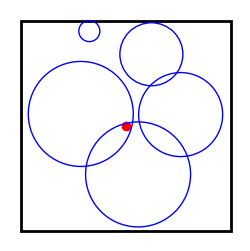

  6%|▌         | 401/7000 [03:45<1:20:56,  1.36it/s]

##########################


  7%|▋         | 500/7000 [04:42<58:16,  1.86it/s]  

Epcoh 500
Packing Density : 0.35646
Circle Config : 


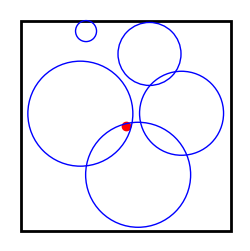

  7%|▋         | 501/7000 [04:42<1:01:05,  1.77it/s]

##########################


  9%|▊         | 600/7000 [05:36<59:07,  1.80it/s]  

Epcoh 600
Packing Density : 0.36001
Circle Config : 


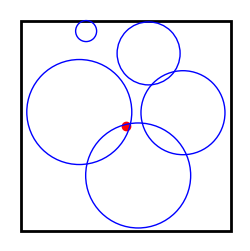

  9%|▊         | 601/7000 [05:37<1:01:06,  1.75it/s]

##########################


 10%|█         | 700/7000 [06:33<1:00:17,  1.74it/s]

Epcoh 700
Packing Density : 0.36112
Circle Config : 


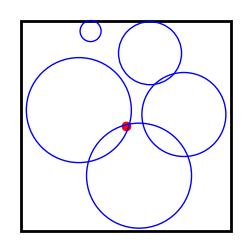

 10%|█         | 701/7000 [06:34<1:01:46,  1.70it/s]

##########################


 11%|█▏        | 800/7000 [07:28<56:34,  1.83it/s]  

Epcoh 800
Packing Density : 0.36284
Circle Config : 


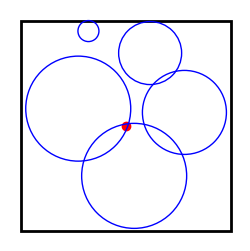

 11%|█▏        | 801/7000 [07:29<58:42,  1.76it/s]

##########################


 13%|█▎        | 900/7000 [08:23<56:20,  1.80it/s]  

Epcoh 900
Packing Density : 0.36208
Circle Config : 


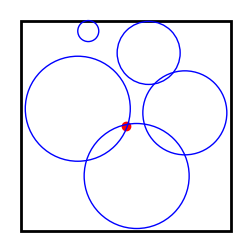

 13%|█▎        | 901/7000 [08:24<58:42,  1.73it/s]

##########################


 14%|█▍        | 1000/7000 [09:17<56:50,  1.76it/s]

Epcoh 1000
Packing Density : 0.36318
Circle Config : 


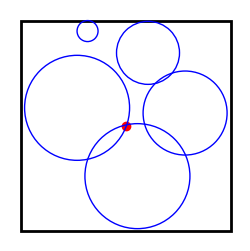

 14%|█▍        | 1001/7000 [09:18<58:07,  1.72it/s]

##########################


 16%|█▌        | 1100/7000 [10:11<51:56,  1.89it/s]

Epcoh 1100
Packing Density : 0.36676
Circle Config : 


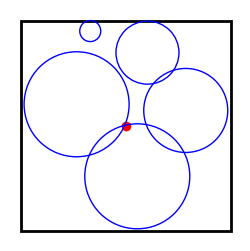

 16%|█▌        | 1101/7000 [10:12<54:34,  1.80it/s]

##########################


 17%|█▋        | 1200/7000 [11:05<52:52,  1.83it/s]

Epcoh 1200
Packing Density : 0.36793
Circle Config : 


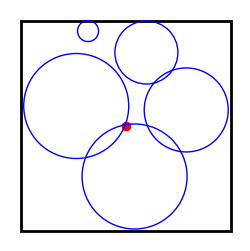

 17%|█▋        | 1201/7000 [11:06<54:33,  1.77it/s]

##########################


 19%|█▊        | 1300/7000 [12:00<51:34,  1.84it/s]

Epcoh 1300
Packing Density : 0.36583
Circle Config : 


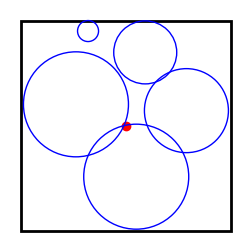

 19%|█▊        | 1301/7000 [12:00<53:26,  1.78it/s]

##########################


 20%|██        | 1400/7000 [12:54<50:52,  1.83it/s]

Epcoh 1400
Packing Density : 0.36871
Circle Config : 


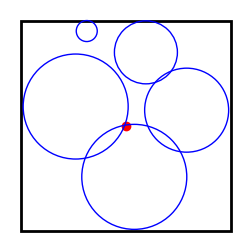

 20%|██        | 1401/7000 [12:54<53:50,  1.73it/s]

##########################


 21%|██▏       | 1500/7000 [13:48<48:42,  1.88it/s]

Epcoh 1500
Packing Density : 0.36989
Circle Config : 


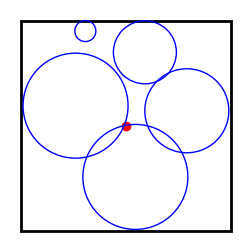

 21%|██▏       | 1501/7000 [13:48<52:18,  1.75it/s]

##########################


 23%|██▎       | 1600/7000 [14:42<48:37,  1.85it/s]

Epcoh 1600
Packing Density : 0.3685
Circle Config : 


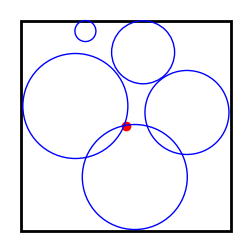

 23%|██▎       | 1601/7000 [14:42<50:45,  1.77it/s]

##########################


 24%|██▍       | 1700/7000 [15:36<47:58,  1.84it/s]

Epcoh 1700
Packing Density : 0.37285
Circle Config : 


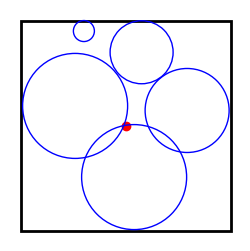

 24%|██▍       | 1701/7000 [15:36<49:19,  1.79it/s]

##########################


 26%|██▌       | 1800/7000 [16:30<46:09,  1.88it/s]

Epcoh 1800
Packing Density : 0.3722
Circle Config : 


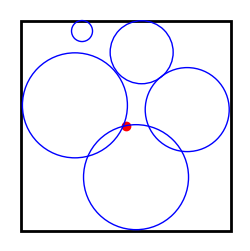

 26%|██▌       | 1801/7000 [16:31<49:51,  1.74it/s]

##########################


 27%|██▋       | 1900/7000 [17:25<45:41,  1.86it/s]

Epcoh 1900
Packing Density : 0.37047
Circle Config : 


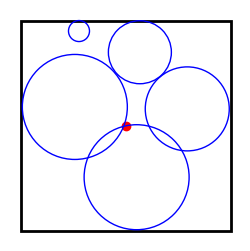

 27%|██▋       | 1901/7000 [17:26<48:48,  1.74it/s]

##########################


 29%|██▊       | 2000/7000 [18:19<44:20,  1.88it/s]

Epcoh 2000
Packing Density : 0.37227
Circle Config : 


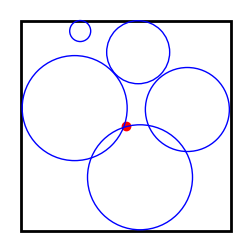

 29%|██▊       | 2001/7000 [18:20<46:14,  1.80it/s]

##########################


 30%|███       | 2100/7000 [19:13<44:29,  1.84it/s]

Epcoh 2100
Packing Density : 0.37425
Circle Config : 


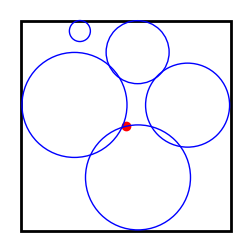

 30%|███       | 2101/7000 [19:14<46:08,  1.77it/s]

##########################


 31%|███▏      | 2200/7000 [20:07<42:22,  1.89it/s]

Epcoh 2200
Packing Density : 0.37527
Circle Config : 


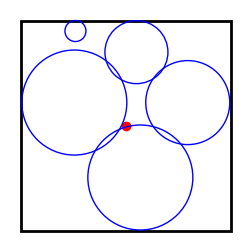

 31%|███▏      | 2201/7000 [20:08<46:38,  1.72it/s]

##########################


 33%|███▎      | 2300/7000 [21:02<42:48,  1.83it/s]

Epcoh 2300
Packing Density : 0.37574
Circle Config : 


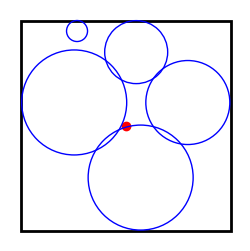

 33%|███▎      | 2301/7000 [21:02<45:04,  1.74it/s]

##########################


 34%|███▍      | 2400/7000 [21:57<42:11,  1.82it/s]

Epcoh 2400
Packing Density : 0.37582
Circle Config : 


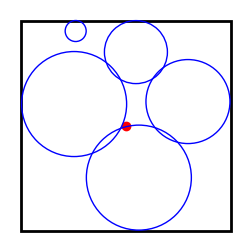

 34%|███▍      | 2401/7000 [21:58<43:38,  1.76it/s]

##########################


 36%|███▌      | 2500/7000 [22:51<39:16,  1.91it/s]

Epcoh 2500
Packing Density : 0.37392
Circle Config : 


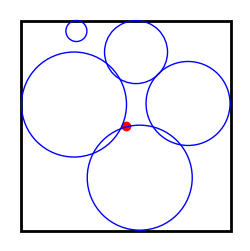

 36%|███▌      | 2501/7000 [22:52<42:33,  1.76it/s]

##########################


 37%|███▋      | 2600/7000 [23:48<39:11,  1.87it/s]

Epcoh 2600
Packing Density : 0.37473
Circle Config : 


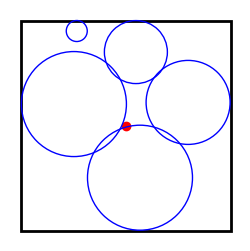

 37%|███▋      | 2601/7000 [23:48<40:32,  1.81it/s]

##########################


 39%|███▊      | 2700/7000 [24:42<39:43,  1.80it/s]

Epcoh 2700
Packing Density : 0.37551
Circle Config : 


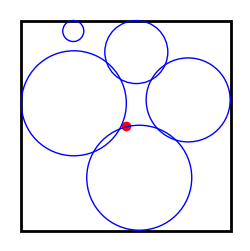

 39%|███▊      | 2701/7000 [24:43<41:09,  1.74it/s]

##########################


 40%|████      | 2800/7000 [25:38<41:53,  1.67it/s]

Epcoh 2800
Packing Density : 0.37409
Circle Config : 


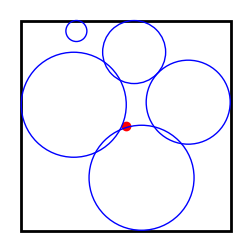

 40%|████      | 2801/7000 [25:39<44:40,  1.57it/s]

##########################


 41%|████▏     | 2900/7000 [26:34<37:53,  1.80it/s]

Epcoh 2900
Packing Density : 0.37705
Circle Config : 


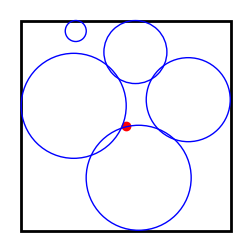

 41%|████▏     | 2901/7000 [26:34<39:58,  1.71it/s]

##########################


 43%|████▎     | 3000/7000 [27:31<39:31,  1.69it/s]

Epcoh 3000
Packing Density : 0.3764
Circle Config : 


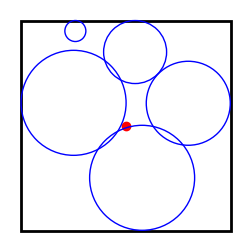

 43%|████▎     | 3001/7000 [27:32<40:54,  1.63it/s]

##########################


 44%|████▍     | 3100/7000 [28:29<39:36,  1.64it/s]

Epcoh 3100
Packing Density : 0.37603
Circle Config : 


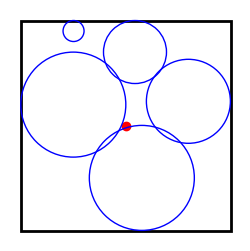

 44%|████▍     | 3101/7000 [28:30<42:50,  1.52it/s]

##########################


 46%|████▌     | 3200/7000 [29:26<39:16,  1.61it/s]

Epcoh 3200
Packing Density : 0.37809
Circle Config : 


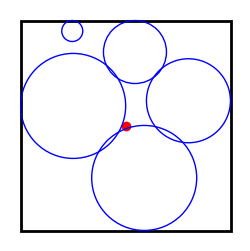

 46%|████▌     | 3201/7000 [29:27<41:31,  1.52it/s]

##########################


 47%|████▋     | 3300/7000 [30:25<33:12,  1.86it/s]

Epcoh 3300
Packing Density : 0.37787
Circle Config : 


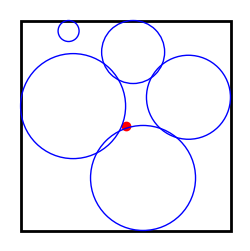

 47%|████▋     | 3301/7000 [30:26<34:35,  1.78it/s]

##########################


 49%|████▊     | 3400/7000 [31:20<32:29,  1.85it/s]

Epcoh 3400
Packing Density : 0.3796
Circle Config : 


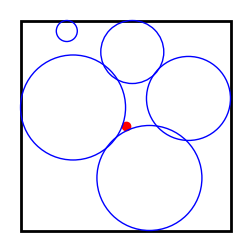

 49%|████▊     | 3401/7000 [31:20<33:43,  1.78it/s]

##########################


 50%|█████     | 3500/7000 [32:16<31:24,  1.86it/s]

Epcoh 3500
Packing Density : 0.37778
Circle Config : 


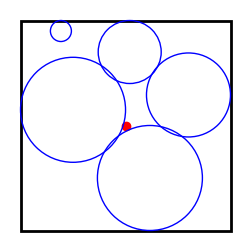

 50%|█████     | 3501/7000 [32:16<33:11,  1.76it/s]

##########################


 51%|█████▏    | 3600/7000 [33:13<31:06,  1.82it/s]

Epcoh 3600
Packing Density : 0.37943
Circle Config : 


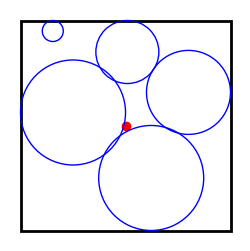

 51%|█████▏    | 3601/7000 [33:13<33:48,  1.68it/s]

##########################


 53%|█████▎    | 3700/7000 [34:07<29:11,  1.88it/s]

Epcoh 3700
Packing Density : 0.3792
Circle Config : 


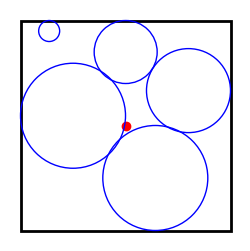

 53%|█████▎    | 3701/7000 [34:08<31:33,  1.74it/s]

##########################


 54%|█████▍    | 3800/7000 [35:01<28:44,  1.86it/s]

Epcoh 3800
Packing Density : 0.37901
Circle Config : 


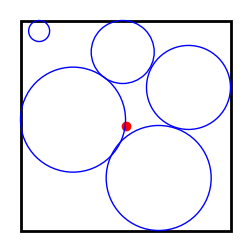

 54%|█████▍    | 3801/7000 [35:02<29:57,  1.78it/s]

##########################


 56%|█████▌    | 3900/7000 [35:55<28:02,  1.84it/s]

Epcoh 3900
Packing Density : 0.37888
Circle Config : 


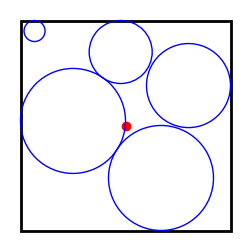

 56%|█████▌    | 3901/7000 [35:56<29:12,  1.77it/s]

##########################


 57%|█████▋    | 4000/7000 [36:50<26:30,  1.89it/s]

Epcoh 4000
Packing Density : 0.38131
Circle Config : 


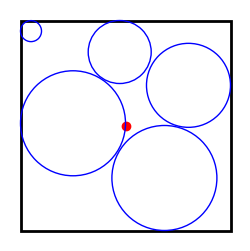

 57%|█████▋    | 4002/7000 [36:50<15:27,  3.23it/s]

##########################


 58%|█████▊    | 4089/7000 [36:50<00:29, 99.08it/s]

Epcoh 4100
Packing Density : 0.38122
Circle Config : 


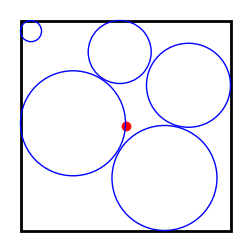

 59%|█████▊    | 4109/7000 [36:50<00:27, 106.11it/s]

##########################


 60%|█████▉    | 4192/7000 [36:51<00:15, 185.08it/s]

Epcoh 4200
Packing Density : 0.38035
Circle Config : 


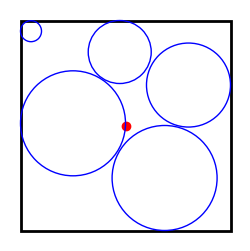

 60%|██████    | 4216/7000 [36:51<00:16, 164.94it/s]

##########################


 61%|██████    | 4265/7000 [36:51<00:13, 197.80it/s]

Epcoh 4300
Packing Density : 0.38135
Circle Config : 


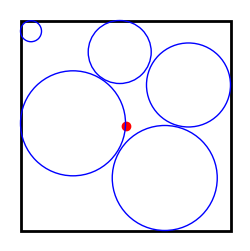

 61%|██████▏   | 4301/7000 [36:51<00:13, 195.71it/s]

##########################


 62%|██████▏   | 4366/7000 [36:51<00:10, 248.53it/s]

Epcoh 4400
Packing Density : 0.38094
Circle Config : 


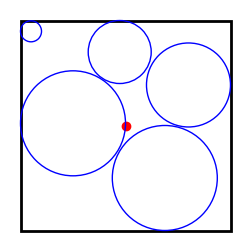

 63%|██████▎   | 4401/7000 [36:52<00:11, 226.89it/s]

##########################


 64%|██████▍   | 4465/7000 [36:52<00:10, 250.83it/s]

Epcoh 4500
Packing Density : 0.38127
Circle Config : 


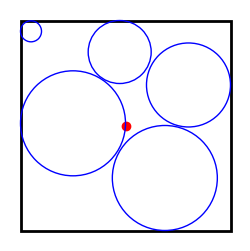

 64%|██████▍   | 4501/7000 [36:52<00:10, 228.82it/s]

##########################


 65%|██████▌   | 4584/7000 [36:52<00:09, 251.27it/s]

Epcoh 4600
Packing Density : 0.38166
Circle Config : 


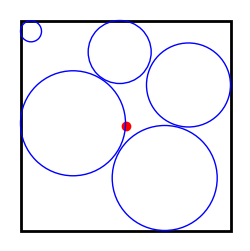

 66%|██████▌   | 4611/7000 [36:52<00:11, 213.28it/s]

##########################


 67%|██████▋   | 4673/7000 [36:53<00:09, 255.62it/s]

Epcoh 4700
Packing Density : 0.37777
Circle Config : 


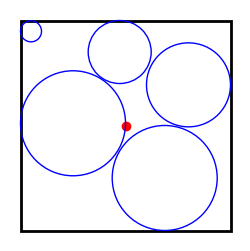

 67%|██████▋   | 4701/7000 [36:53<00:10, 224.48it/s]

##########################


 68%|██████▊   | 4771/7000 [36:53<00:07, 279.42it/s]

Epcoh 4800
Packing Density : 0.3789
Circle Config : 


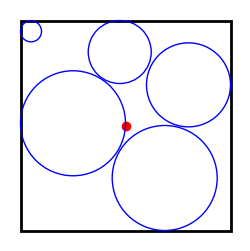

 69%|██████▊   | 4801/7000 [36:53<00:09, 237.83it/s]

##########################


 70%|██████▉   | 4897/7000 [36:54<00:07, 282.65it/s]

Epcoh 4900
Packing Density : 0.37832
Circle Config : 


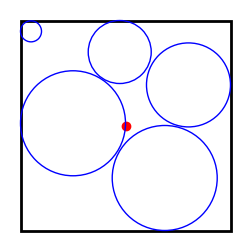

 70%|███████   | 4927/7000 [36:54<00:08, 236.39it/s]

##########################


 71%|███████▏  | 4996/7000 [36:54<00:07, 282.59it/s]

Epcoh 5000
Packing Density : 0.37934
Circle Config : 


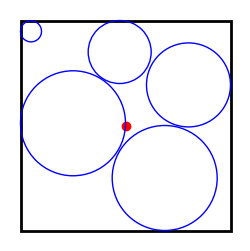

 72%|███████▏  | 5027/7000 [36:54<00:08, 232.44it/s]

##########################


 73%|███████▎  | 5087/7000 [36:54<00:07, 254.44it/s]

Epcoh 5100
Packing Density : 0.38246
Circle Config : 


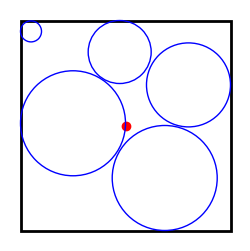

 73%|███████▎  | 5115/7000 [36:55<00:09, 203.69it/s]

##########################


 74%|███████▍  | 5173/7000 [36:55<00:08, 226.75it/s]

Epcoh 5200
Packing Density : 0.37895
Circle Config : 


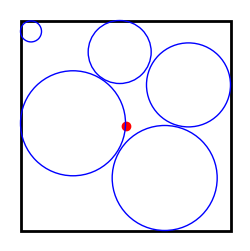

 74%|███████▍  | 5201/7000 [36:55<00:08, 207.94it/s]

##########################


 75%|███████▌  | 5268/7000 [36:55<00:06, 262.56it/s]

Epcoh 5300
Packing Density : 0.38028
Circle Config : 


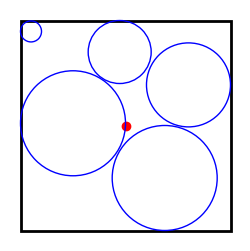

 76%|███████▌  | 5301/7000 [36:55<00:07, 228.12it/s]

##########################


 77%|███████▋  | 5384/7000 [36:56<00:06, 253.74it/s]

Epcoh 5400
Packing Density : 0.37607
Circle Config : 


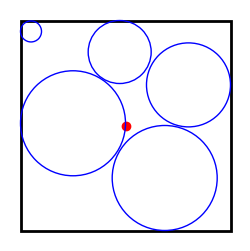

 77%|███████▋  | 5411/7000 [36:56<00:07, 207.89it/s]

##########################


 78%|███████▊  | 5478/7000 [36:56<00:05, 262.11it/s]

Epcoh 5500
Packing Density : 0.37922
Circle Config : 


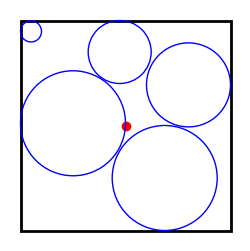

 79%|███████▊  | 5507/7000 [36:56<00:06, 231.65it/s]

##########################


 80%|███████▉  | 5599/7000 [36:57<00:05, 270.68it/s]

Epcoh 5600
Packing Density : 0.37887
Circle Config : 


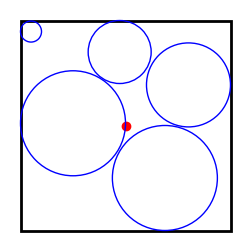

 80%|████████  | 5628/7000 [36:57<00:06, 216.10it/s]

##########################


 81%|████████▏ | 5690/7000 [36:57<00:05, 255.25it/s]

Epcoh 5700
Packing Density : 0.38179
Circle Config : 


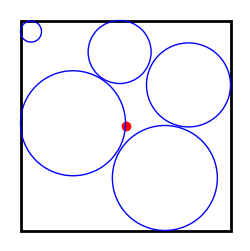

 82%|████████▏ | 5718/7000 [36:57<00:05, 219.66it/s]

##########################


 83%|████████▎ | 5778/7000 [36:57<00:05, 240.03it/s]

Epcoh 5800
Packing Density : 0.37882
Circle Config : 


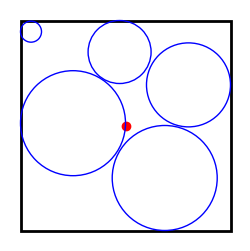

 83%|████████▎ | 5804/7000 [36:57<00:05, 213.71it/s]

##########################


 84%|████████▍ | 5864/7000 [36:58<00:04, 249.87it/s]

Epcoh 5900
Packing Density : 0.37876
Circle Config : 


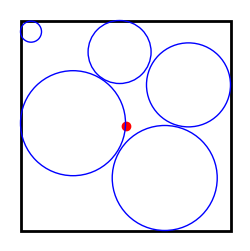

 84%|████████▍ | 5901/7000 [36:58<00:04, 232.58it/s]

##########################


 85%|████████▌ | 5969/7000 [36:58<00:03, 278.30it/s]

Epcoh 6000
Packing Density : 0.38226
Circle Config : 


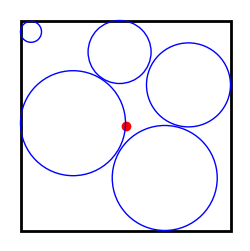

 86%|████████▌ | 6001/7000 [36:58<00:04, 239.69it/s]

##########################


 87%|████████▋ | 6067/7000 [36:58<00:03, 277.72it/s]

Epcoh 6100
Packing Density : 0.38092
Circle Config : 


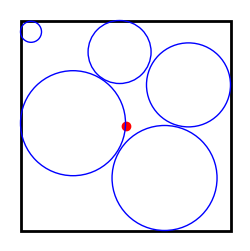

 87%|████████▋ | 6101/7000 [36:59<00:03, 237.96it/s]

##########################


 88%|████████▊ | 6183/7000 [36:59<00:03, 245.56it/s]

Epcoh 6200
Packing Density : 0.37724
Circle Config : 


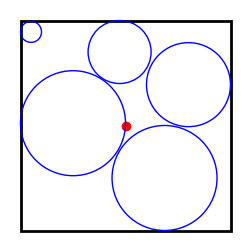

 89%|████████▊ | 6209/7000 [36:59<00:03, 211.16it/s]

##########################


 90%|████████▉ | 6275/7000 [36:59<00:02, 260.65it/s]

Epcoh 6300
Packing Density : 0.37865
Circle Config : 


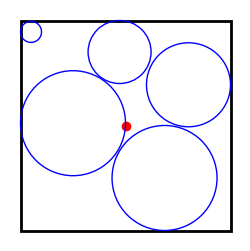

 90%|█████████ | 6303/7000 [37:00<00:03, 225.70it/s]

##########################


 91%|█████████ | 6369/7000 [37:00<00:02, 269.14it/s]

Epcoh 6400
Packing Density : 0.37688
Circle Config : 


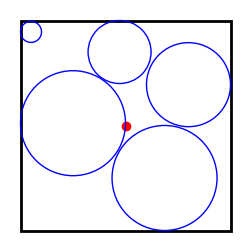

 91%|█████████▏| 6401/7000 [37:00<00:02, 233.12it/s]

##########################


 93%|█████████▎| 6499/7000 [37:00<00:01, 284.13it/s]

Epcoh 6500
Packing Density : 0.37905
Circle Config : 


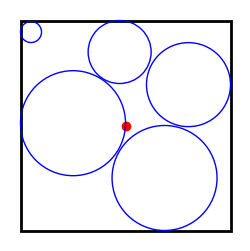

 94%|█████████▍| 6563/7000 [37:01<00:02, 192.54it/s]

##########################


 94%|█████████▍| 6599/7000 [37:01<00:01, 225.86it/s]

Epcoh 6600
Packing Density : 0.37922
Circle Config : 


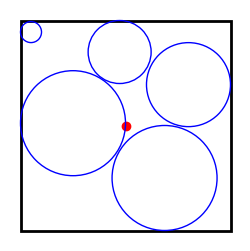

 95%|█████████▍| 6629/7000 [37:01<00:01, 197.83it/s]

##########################


 96%|█████████▌| 6685/7000 [37:01<00:01, 217.97it/s]

Epcoh 6700
Packing Density : 0.38385
Circle Config : 


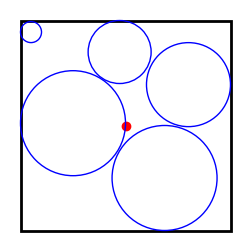

 96%|█████████▌| 6711/7000 [37:01<00:01, 192.74it/s]

##########################


 97%|█████████▋| 6773/7000 [37:02<00:00, 239.72it/s]

Epcoh 6800
Packing Density : 0.37819
Circle Config : 


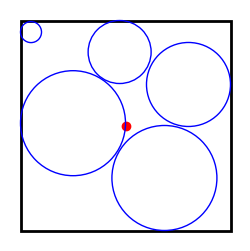

 97%|█████████▋| 6801/7000 [37:02<00:00, 214.76it/s]

##########################


 99%|█████████▊| 6900/7000 [37:02<00:00, 282.99it/s]

Epcoh 6900
Packing Density : 0.38099
Circle Config : 


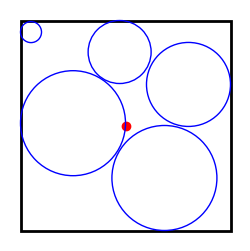

##########################


100%|██████████| 7000/7000 [37:03<00:00,  3.15it/s] 


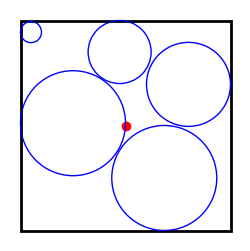

In [54]:
# Parameters
num_circles = 5  ## r = 0.5, 0.4, 0.3, 0.2, 0.1
small_radius = torch.tensor(([0.5], [0.5], [0.4], [0.3], [0.1]))
large_radius = torch.ones_like(small_radius)*1.414
BATCHES = 200
EPOCHS = 7000

# Initialize input data and loss function
eye = one_hot(np.arange(0, num_circles), num_circles)
Input = eye.repeat(BATCHES, 1, 1)

model = EncoderDecoder(num_circles, large_radius, small_radius)


loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.0005)
optim2 = torch.optim.Adam(model.parameters(), lr=0.00005)
alpha = 2
beta = 8

# Training loop
for epoch in tqdm(range(EPOCHS)):
    if epoch == 500 :
        alpha = 4
        beta = 8
    if epoch == 1000 :
        alpha = 8
        beta = 8
    if epoch == 2000 :
        alpha = 2
        beta = 2
    if epoch == 3000 :
        alpha = 0.5
        beta = 0.5
    if epoch < 4000:
        for inputs in Input:           
            optim.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, inputs.argmax(dim=1))
            curr_loss.backward()
            optim.step()
    if epoch >= 4000:
            optim2.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, inputs.argmax(dim=1))
            curr_loss.backward()
            optim2.step()
    if epoch % 100 == 0:
        print(f"Epcoh {epoch}") 
        centres = model.centres(eye)
        print(f"Packing Density : {packing_density(centres, small_radius.numpy(), large_radius.numpy())}")
        print(f"Circle Config : ")
        plot_circles(centres, large_radius, small_radius)
        print("##########################")

centres = model.centres(eye)
plot_circles(centres, large_radius, small_radius)

In [ ]:
# ########### MODEL CLASSES ###############


# class NormalizationLayer(nn.Module):
#     def __init__(self, maxnorm, input_shape):
#         super(NormalizationLayer, self).__init__()
#         self.maxnorm = maxnorm
#         self.weight = torch.nn.Parameter(data=torch.randn(input_shape),requires_grad=True)
#         self.sigmoid = nn.Sigmoid()
#         self.a = torch.nn.Parameter(data=torch.randn(input_shape[0],1), requires_grad=True)
        
        
#     def forward(self, inputs):
#         output = inputs * (self.weight / torch.norm(self.weight, dim=1, p=2, keepdim=True)) * self.maxnorm * self.sigmoid(self.a)
#         return output
    
# class NoiseLayer(nn.Module):
#     def __init__(self, noise_radius):
#         super(NoiseLayer, self).__init__()
#         self.noise_radius = noise_radius
#         self.alpha = 0.5
        
#     def spherical_gaussian(self, num_circles):
#         x = torch.randn(num_circles, 2)
#         u = torch.rand(num_circles, 1)
#         norm = torch.norm(x, dim=1, keepdim=True, p=2)
#         noise = x * (u.pow(self.alpha)) * self.noise_radius / norm
#         return noise

#     def forward(self, inputs, alpha):
#         self.alpha = alpha
#         noise = self.spherical_gaussian(inputs.size(0))
#         return inputs + noise
    

# class EncoderDecoder(nn.Module):
#     def __init__(self, num_circles, larger_radius, smaller_radius):
#         super(EncoderDecoder, self).__init__()
        
#         self.main_dim = num_circles
#         self.latent_dim = 2
#         self.R = larger_radius
#         self.r = smaller_radius
#         self.mid_dim = 30
#         self.alpha = 0.5

#         self.normalize = NormalizationLayer(self.R - self.r, (num_circles, 2))       
#         self.noise = NoiseLayer(self.r)
        
#         self.encoder = nn.Sequential(
#             nn.Linear(self.main_dim, self.mid_dim),
#             nn.SELU(),
#             nn.Linear(self.mid_dim, self.main_dim),
#             nn.SELU(),
#             nn.Linear(self.main_dim, self.latent_dim),
#             nn.Tanh()
#         )       
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, self.main_dim),
#             nn.ReLU(),
#             nn.Linear(self.main_dim, self.mid_dim),
#             nn.ReLU(),
#             nn.Linear(self.mid_dim, self.main_dim),
#             nn.Softmax(dim=1)
#         )
        
#     def forward(self, x, alpha):
#         self.alpha = alpha
#         encoded = self.encoder(x)
#         normed_encoded = self.normalize(encoded)
#         noisy_encoded = self.noise(normed_encoded, alpha)
#         decoded = self.decoder(noisy_encoded)
#         return decoded

#     def centres(self, x):
#         return self.normalize(self.encoder(x)).detach().numpy()